In [60]:
import os
import pickle
import networkx as nx
import fa2
import numpy as np

from datautils import (
    datautils,
)
from graph import graph
from style import style

from matplotlib import cm
from matplotlib.pyplot import plot
import seaborn as sns
import numpy as np

In [61]:
FA_POSITIONS_ALL = "graph/positions.pickle"
UNIVERSE_EDGELIST_PATH = "graph/universe.edgelist"

### Loading the data

In [62]:
if os.path.exists('data/data_all.pickle'):
    with open('data/data_all.pickle', "rb") as rbfile:
        data = pickle.load(rbfile)
else:
    loader = datautils.Loader()
    loader.load("data/characters/")
    data = loader.to_dataframe()
    loader.drop()

### Creating Graphs

* Directed Graph,
* Directed Largest Connected Components Graph
* Un-directed Largest Connected Components Graph

In [63]:
if os.path.exists(UNIVERSE_EDGELIST_PATH):
    Universe = nx.read_edgelist(UNIVERSE_EDGELIST_PATH, create_using=nx.DiGraph)
else:
    Universe = graph.create_directed_graph(data)
    # save graph as an edgelist
    nx.write_edgelist(Universe,UNIVERSE_EDGELIST_PATH)

style.print_header("Directed graph")
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")
print()

Universe_CC = graph.connected_components(Universe)
style.print_header("Large Connected Components directed graph")
print(f"Number of nodes: {len(Universe_CC.nodes)}")
print(f"Number of links: {len(Universe_CC.edges)}")
print()

Universe_CC_undirected = Universe_CC.to_undirected()
style.print_header("Large Connected Components undirected graph")
print(f"Number of nodes: {len(Universe_CC_undirected.nodes)}")
print(f"Number of links: {len(Universe_CC_undirected.edges)}")

==================== Directed graph ====================

Number of nodes: 22976
Number of links: 91976

==================== Large Connected Components directed graph ====================

Number of nodes: 19110
Number of links: 86659

==================== Large Connected Components undirected graph ====================

Number of nodes: 19110
Number of links: 62768


### From further analysis only Largest Connected Component (LCC) graph will be used

==================== Universe stats ====================

In degree: {'mean': 4.534746206174778, 'median': 2.0, 'mode': 1, 'min': 0, 'max': 915}
Out degree: {'mean': 4.534746206174778, 'median': 3.0, 'mode': 1, 'min': 0, 'max': 390}

Calculating best minimal value for power law fit
In degree slope: 2.55


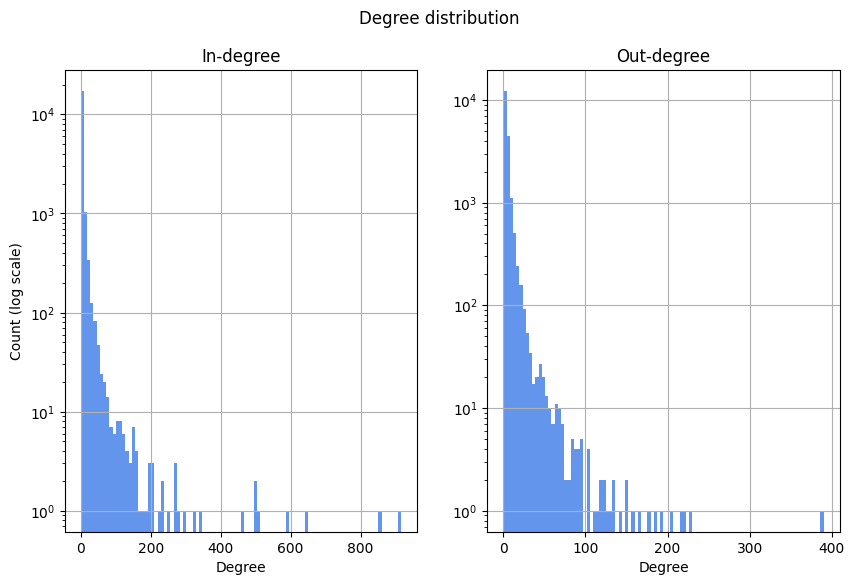

In [64]:
# calculater degree distributions
style.print_header("Universe stats")
in_stats = graph.calc_stats(Universe_CC.in_degree())
out_stats = graph.calc_stats(Universe_CC.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

print()
print(f"In degree slope: {graph.power_law_fit(Universe_CC):.2f}")    

in_degree, out_degree = graph.plot_degree_distribution(Universe_CC, scale = 'log')

### Visualize Base Graph

[]

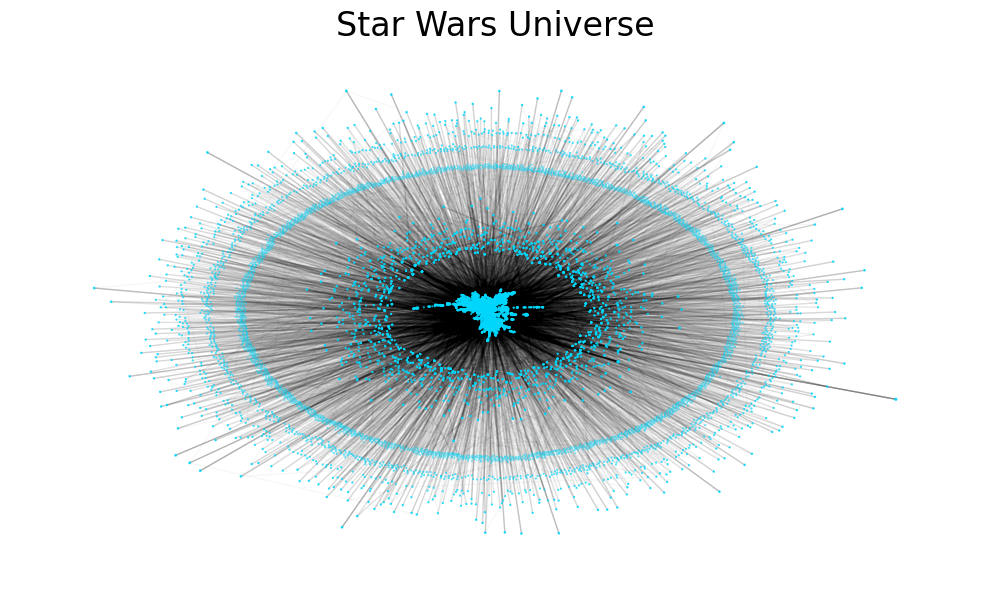

In [65]:

# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS_ALL):
    with open(FA_POSITIONS_ALL, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(
        verbose=False,
    ).forceatlas2_networkx_layout(
        Universe_CC,
        pos=None,
        iterations=2000,
    )
    # save to pickle for later use
    with open(FA_POSITIONS_ALL, "wb") as wbfile:
        pickle.dump(positions, wbfile)

_ = graph.plot_graph_with_positons(
    Universe_CC_undirected,
    positions,
    "Star Wars Universe",
    node_alpha=0.8,
    node_size_factor=0.1,
    edge_alpha=0.03,
)
plot()

### Most popular characters

In [42]:
style.print_header("Characters with the largest number of in degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "In degree"))

in_degree_sorted = np.argsort(in_degree)[::-1]
nodes_list = list(Universe_CC.nodes())
for i in range(10):
    character = nodes_list[in_degree_sorted[i]]
    degree = Universe_CC.in_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

print()
style.print_header("Characters with the largest number of out degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "Out degree"))

out_degree_sorted = np.argsort(out_degree)[::-1]
for i in range(10):
    character = nodes_list[out_degree_sorted[i]] 
    degree = Universe_CC.out_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

==================== Characters with the biggest number of in degree ====================

no. Character                     In degree
1   Anakin Skywalker              915
2   Leia Organa Solo              852
3   Darth Sidious                 648
4   Ruwan Tokai                   590
5   Han Solo                      506
6   Obi-Wan Kenobi                501
7   Leia Skywalker Organa Solo    496
8   Luke Skywalker                461
9   Ahsoka Tano                   340
10  Chewbacca                     327

==================== Characters with the biggest number of out degree ====================

no. Character                     Out degree
1   Anakin Skywalker              390
2   Obi-Wan Kenobi                229
3   Leia Skywalker Organa Solo    222
4   Darth Caedus                  218
5   Ahsoka Tano                   204
6   Corran Horn                   194
7   Jaina Solo Fel                186
8   Mitth'raw'nuruodo             178
9   Han Solo                      164
10  L

Wookiepedia contains two pages for princess Leia character. It was decided to proceed with analysis with both of them, because both articles are rich in content.

1. [Leia Skywalker Organa Solo](https://starwars.fandom.com/wiki/Leia_Skywalker_Organa_Solo?so=search)
2. [Leia Organa Solo](https://starwars.fandom.com/wiki/Leia_Organa_Solo)

In [7]:
# Leia character is repeated in the data
data[data.Name.isin(["Leia_Skywalker_Organa_Solo", "Leia_Organa_Solo"])]

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died
13413,Leia_Organa_Solo,Leia Organa Solo,"Leia Organa Solo , a Force-sensitive Human fem...","[Star_Wars_Legends, Wookieepedia:Featured_arti...",Human,Female,"[Galactic Empire, House Organa, Alderaanian Re...",Alderaan,"[0 ABY, Bedlam, 2 ABY, Mimban]"
13414,Leia_Skywalker_Organa_Solo,Leia Skywalker Organa Solo,Leia Skywalker Organa Solo was a Force-sensiti...,"[Canon, Leia_Skywalker_Organa_Solo, Leia_Organ...",Human,Female,"[Skywalker family, Elder Houses, House of Orga...",Alderaan,"[35 ABY, Ajan Kloss]"


### Finding communities in the universe

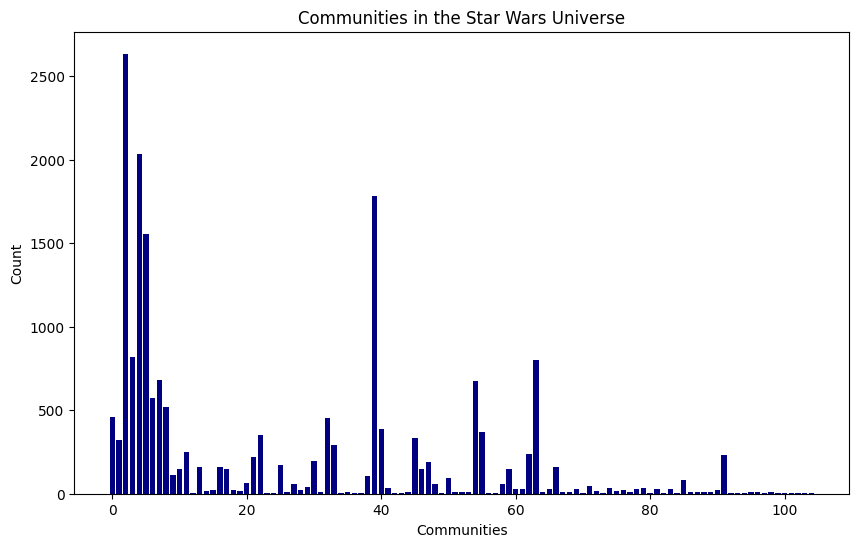

In [8]:
partition, communities, mod = graph.find_communities(Universe_CC_undirected)
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Communities in the Star Wars Universe",
    xlabel="Communities",
)

In [9]:
# separate only communities with the size bigger than 500 to color them
biggest_communities = []

for key, val in communities.items():
    if val > 500:
        biggest_communities.append(key)

biggest_communities_node = dict()
for key, val in partition.items():
    if val in biggest_communities:
        biggest_communities_node[key] = val

data_biggest_communities = data.loc[data['Name'].isin(biggest_communities_node.keys())].reset_index(drop=True)

partition_biggest_communities = []
for n in data_biggest_communities.Name:
    partition_biggest_communities.append(biggest_communities_node[n])

In [10]:
colors = sns.color_palette("tab10").as_hex()

colors_dict = dict()
for i, c in enumerate(biggest_communities):
    colors_dict[c] = colors[i]

color_map = []

for i in partition.values():
    if i in biggest_communities:
        color_map.append(colors_dict[i])
    else:
        color_map.append('lightgrey')

## Visualizing universe with coloring communities with more than 500 members

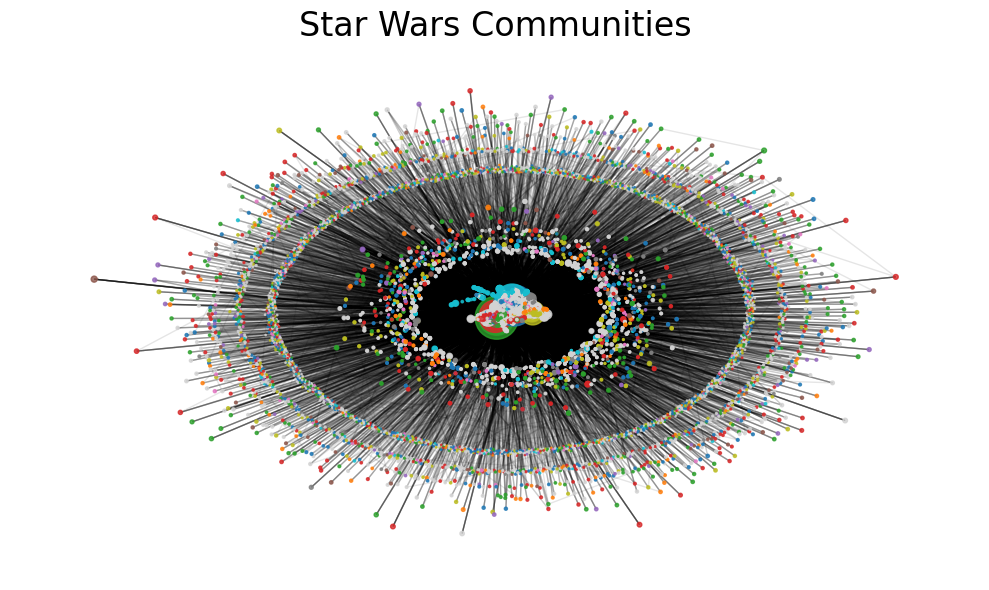

In [11]:
node_degrees = sorted(Universe_CC_undirected.degree, key=lambda x: x[1], reverse=True)
labels = dict([(name[0], data[data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:10]])

cmap = cm.get_cmap("tab10", max(partition.values()) + 1)

graph.plot_graph_with_positons(
    Universe_CC_undirected,
    positions,
    "Star Wars Communities",
    node_color=color_map
)